# **Mental Health Analysis using NLP**
In this project, we will try to classify a person's mental health on the basis of some text. We will use different NLP techniques such as text preprocessing, vectorization using word embeddings etc, different models and architectures will be used for the classification. The dataset contains text messages and their respective labels such as 1 for poisonous with mental health issues and 0 for normal. These classifications can be used as early diagnosis for potential mental health patients.

In [59]:
# import the essential libraries and dependencies
import pandas as pd
import numpy as np
import spacy
import gensim
import gensim.downloader as api
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras

In [3]:
# import the data
df = pd.read_csv('mental_health.csv')
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


**Exploratory Data Analysis**

In [5]:
print("Number of rows in dataset: ",df.shape[0])

Number of rows in dataset:  27977


In [6]:
df['label'].value_counts()

0    14139
1    13838
Name: label, dtype: int64

In [7]:
# we can see their is no imbalance in the dataset
df.dtypes

text     object
label     int64
dtype: object

In [16]:
# checking for null values
df.isna().sum()

text     0
label    0
dtype: int64

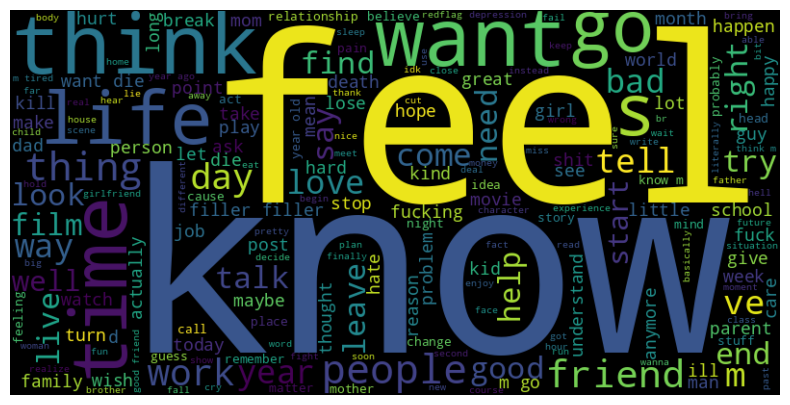

In [15]:
# create a word cloud
text_corpus = ' '.join(df['text'].values)

wordcloud = WordCloud(width=800,height=400).generate(text_corpus)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Text Preprocessing**

In [8]:
# we will be using spacy for
# using spacy's english language model(small)
nlp = spacy.load("en_core_web_sm")

In [9]:
def preprocess_text(text):
  doc = nlp(str(text))

  filtered_tokens = []
  for token in doc:
    if token.is_stop or token.is_punct:
      continue # do not consider stop words(is, an, the etc) or punctuations
    else:
      filtered_tokens.append(token.lemma_) # this will only append the token after lemmatization (converting a word to its base word)
  return  " ".join(filtered_tokens) # would return a string instead of a list



In [10]:
# testing the function
preprocess_text("The skies look beautiful today.")

'sky look beautiful today'

In [11]:
# we will now run this function on our text
df["text"] = df["text"].apply(lambda text: preprocess_text(text))

In [13]:
df['text'][0]

'dear american teen question dutch person hear guy way easy thing learn age sooooo thth grader like   right guy learn math'

**Text Vecotorization**

Computers can not understand text like humans, so we need to convert the text from string to numbers, the process is Vectorization. We will use Word Embedding techniques such as GLoVE.

In [19]:
# we will load a small model by gensim to implement word embeddings
wv = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [22]:
def vectorize_text(text):
  return wv.get_mean_vector(list(text.split(" "))) # this would return the mean vector of all the words in the sentence


In [23]:
df['vectorizedText'] = df['text'].apply(lambda text: vectorize_text(text)) # created a new column for vectorized text

In [24]:
df.head()

,text,label,vectorizedText
0,dear american teen question dutch person hear ...,0,"[-0.039536584, 0.022813024, -0.027770927, -0.0..."
1,look forward lifei not reason go feel like kee...,1,"[0.02550498, -0.0018092801, 0.028318249, -0.06..."
2,music recommendation m look expand playlist us...,0,"[-0.03627585, 0.038025357, -0.043538924, -0.01..."
3,m try feel betterthe reason m alive know mum d...,1,"[0.026183447, 0.026436856, 0.05874272, -0.0297..."
4,worry year old girl subject domestic physica...,1,"[0.045394175, 0.009076429, -0.009327763, -0.05..."


In [26]:
df['vectorizedText'][0].shape # the function converted text into a vector of shape

(50,)

In [28]:
type(df['vectorizedText'][0])

numpy.ndarray

**Train Test Split**

In [30]:
X = df['vectorizedText'].values
y = df['label']

X_train,X_test,y_train,y_test = train_test_split(
    X,y,
    test_size = 0.2,
    stratify = y,
    random_state = 20
)

In [31]:
X_train.shape

(22381,)

In [33]:
X_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [34]:
# convert into 2D numpy array
X_train_2d  = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [35]:
X_train_2d[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [40]:
# to remove negative values we perform scaling using MinMaxScalar
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

**Naive Bayes Classifier**

In [41]:
# build the model
clf_nb = MultinomialNB()

# train the model
clf_nb.fit(X_train_scaled,y_train)

MultinomialNB()

In [43]:
# make predictions
y_pred = clf_nb.predict(X_test_scaled)

In [47]:
# compute accuracy of the model
nb_accuracy = accuracy_score(y_test,y_pred)
nb_accuracy


0.7884203002144389

In [50]:
# print classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      2828
           1       0.82      0.74      0.78      2768

    accuracy                           0.79      5596
   macro avg       0.79      0.79      0.79      5596
weighted avg       0.79      0.79      0.79      5596



**Gradient Boosted Classifier**

In [56]:
# build the model
clf_knn = KNeighborsClassifier()

# train the model
clf_knn.fit(X_train_2d,y_train)

KNeighborsClassifier()

In [57]:
# make predictions
y_pred_knn = clf_knn.predict(X_test_scaled)

# compute accuracy
knn_accuracy = accuracy_score(y_test,y_pred_knn)
knn_accuracy

0.505360972122945

In [58]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      2828
           1       0.50      0.00      0.00      2768

    accuracy                           0.51      5596
   macro avg       0.50      0.50      0.34      5596
weighted avg       0.50      0.51      0.34      5596



**Artifical Neural Network**

In [103]:
# build the ann model
ann_model = keras.Sequential([
    keras.layers.Dense(128,activation='relu',input_shape=(50,1)),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(1,activation='sigmoid')
])

# compile the model
ann_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [98]:
# train the model
ann_model.fit(X_train_2d,y_train,epochs=10)

Epoch 1/10
700/700 [==============================] - 3s 3ms/step - loss: 0.4081 - accuracy: 0.8316
Epoch 2/10
700/700 [==============================] - 3s 4ms/step - loss: 0.3441 - accuracy: 0.8590
Epoch 3/10
700/700 [==============================] - 3s 4ms/step - loss: 0.3281 - accuracy: 0.8666
Epoch 4/10
700/700 [==============================] - 2s 3ms/step - loss: 0.3182 - accuracy: 0.8717
Epoch 5/10
700/700 [==============================] - 2s 3ms/step - loss: 0.3122 - accuracy: 0.8720
Epoch 6/10
700/700 [==============================] - 2s 3ms/step - loss: 0.3072 - accuracy: 0.8736
Epoch 7/10
700/700 [==============================] - 3s 4ms/step - loss: 0.3016 - accuracy: 0.8750
Epoch 8/10
700/700 [==============================] - 3s 4ms/step - loss: 0.2978 - accuracy: 0.8766
Epoch 9/10
700/700 [==============================] - 2s 3ms/step - loss: 0.2924 - accuracy: 0.8806
Epoch 10/10
700/700 [==============================] - 2s 3ms/step - loss: 0.2907 - accuracy: 0.8790

In [99]:
# compute the accuracy
ann_accuracy = ann_model.evaluate(X_test_2d,y_test)[1]
ann_accuracy

175/175 [==============================] - 0s 2ms/step - loss: 0.2913 - accuracy: 0.8797


0.87973552942276

**Recurrent Neural Network**

In [68]:
# build the rnn model
rnn_model = keras.Sequential([
    keras.layers.SimpleRNN(100,input_shape=(50,1),return_sequences=False),
    keras.layers.Dense(1,activation='sigmoid')
])

# compile the model
rnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [69]:
# train the model
rnn_model.fit(X_train_2d,y_train,epochs=10)

Epoch 1/10
700/700 [==============================] - 31s 37ms/step - loss: 0.5686 - accuracy: 0.7190
Epoch 2/10
700/700 [==============================] - 24s 34ms/step - loss: 0.5448 - accuracy: 0.7418
Epoch 3/10
700/700 [==============================] - 22s 31ms/step - loss: 0.5103 - accuracy: 0.7668
Epoch 4/10
700/700 [==============================] - 22s 32ms/step - loss: 0.4925 - accuracy: 0.7767
Epoch 5/10
700/700 [==============================] - 23s 32ms/step - loss: 0.4433 - accuracy: 0.8039
Epoch 6/10
700/700 [==============================] - 22s 32ms/step - loss: 0.4158 - accuracy: 0.8215
Epoch 7/10
700/700 [==============================] - 22s 32ms/step - loss: 0.3974 - accuracy: 0.8317
Epoch 8/10
700/700 [==============================] - 22s 32ms/step - loss: 0.3851 - accuracy: 0.8359
Epoch 9/10
700/700 [==============================] - 21s 31ms/step - loss: 0.3829 - accuracy: 0.8404
Epoch 10/10
700/700 [==============================] - 22s 31ms/step - loss: 0.377

In [70]:
# compute the accuracy
rnn_accuracy = rnn_model.evaluate(X_test_2d,y_test)[1]
rnn_accuracy

175/175 [==============================] - 2s 10ms/step - loss: 0.3462 - accuracy: 0.8490


0.8489992618560791

**Long Short Term Memory Network**

In [78]:
# build the LSTM model
lstm_model = keras.Sequential([
    keras.layers.LSTM(100,input_shape=(50,1),return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1,activation='sigmoid')
])

# compile the lstm model
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [72]:
# train the model
lstm_model.fit(X_train_2d,y_train,epochs=10)

Epoch 1/10
700/700 [==============================] - 9s 7ms/step - loss: 0.6394 - accuracy: 0.6499
Epoch 2/10
700/700 [==============================] - 4s 6ms/step - loss: 0.5264 - accuracy: 0.7627
Epoch 3/10
700/700 [==============================] - 4s 6ms/step - loss: 0.4880 - accuracy: 0.7862
Epoch 4/10
700/700 [==============================] - 5s 7ms/step - loss: 0.4701 - accuracy: 0.7944
Epoch 5/10
700/700 [==============================] - 4s 6ms/step - loss: 0.4643 - accuracy: 0.7952
Epoch 6/10
700/700 [==============================] - 4s 6ms/step - loss: 0.4583 - accuracy: 0.7984
Epoch 7/10
700/700 [==============================] - 5s 7ms/step - loss: 0.4544 - accuracy: 0.8003
Epoch 8/10
700/700 [==============================] - 4s 6ms/step - loss: 0.4543 - accuracy: 0.8014
Epoch 9/10
700/700 [==============================] - 4s 6ms/step - loss: 0.4503 - accuracy: 0.8023
Epoch 10/10
700/700 [==============================] - 5s 7ms/step - loss: 0.4477 - accuracy: 0.8046

In [73]:
# compute the accuracy
lstm_accuracy = lstm_model.evaluate(X_test_2d,y_test)[1]
lstm_accuracy

175/175 [==============================] - 1s 5ms/step - loss: 0.5441 - accuracy: 0.7364


0.7364188432693481

**Gated Recurrent Unit Network**

In [79]:
# build the LSTM model
gru_model = keras.Sequential([
    keras.layers.GRU(100,input_shape=(50,1),return_sequences=False),
    keras.layers.Dense(1,activation='sigmoid')
])

# compile the lstm model
gru_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [80]:
# train the gru model
gru_model.fit(X_train_2d,y_train,epochs=10)

Epoch 1/10
700/700 [==============================] - 8s 6ms/step - loss: 0.6259 - accuracy: 0.6487
Epoch 2/10
700/700 [==============================] - 4s 5ms/step - loss: 0.5320 - accuracy: 0.7530
Epoch 3/10
700/700 [==============================] - 3s 5ms/step - loss: 0.5063 - accuracy: 0.7692
Epoch 4/10
700/700 [==============================] - 4s 6ms/step - loss: 0.4648 - accuracy: 0.7930
Epoch 5/10
700/700 [==============================] - 4s 5ms/step - loss: 0.4412 - accuracy: 0.8084
Epoch 6/10
700/700 [==============================] - 3s 5ms/step - loss: 0.4316 - accuracy: 0.8127
Epoch 7/10
700/700 [==============================] - 4s 6ms/step - loss: 0.4209 - accuracy: 0.8201
Epoch 8/10
700/700 [==============================] - 4s 5ms/step - loss: 0.4118 - accuracy: 0.8220
Epoch 9/10
700/700 [==============================] - 3s 5ms/step - loss: 0.4048 - accuracy: 0.8276
Epoch 10/10
700/700 [==============================] - 3s 5ms/step - loss: 0.3977 - accuracy: 0.8318

In [81]:
gru_accuracy = gru_model.evaluate(X_test_2d,y_test)[1]
gru_accuracy

175/175 [==============================] - 1s 5ms/step - loss: 0.3809 - accuracy: 0.8363


0.8363116383552551

**Comparing the models**

In [100]:
# now we have tested a lot of models now we will compare the accuracy and find the best model

accuracy_df = pd.DataFrame({
    "models" : ["Naive-Bayes","KNN Classifier","Artifical Neural Network","Recurrent Neural Network","Long Short Term Memory","Gated Recurrent Unit"],
    "accuracy" : [nb_accuracy*100,knn_accuracy*100, ann_accuracy*100,rnn_accuracy*100,lstm_accuracy*100,gru_accuracy*100]

})
accuracy_df

,models,accuracy
0,Naive-Bayes,78.842030
1,KNN Classifier,50.536097
2,Artifical Neural Network,87.973553
3,Recurrent Neural Network,84.899926
4,Long Short Term Memory,73.641884
5,Gated Recurrent Unit,83.631164


<Axes: title={'center': 'Model vs Accuracy'}, xlabel='models'>

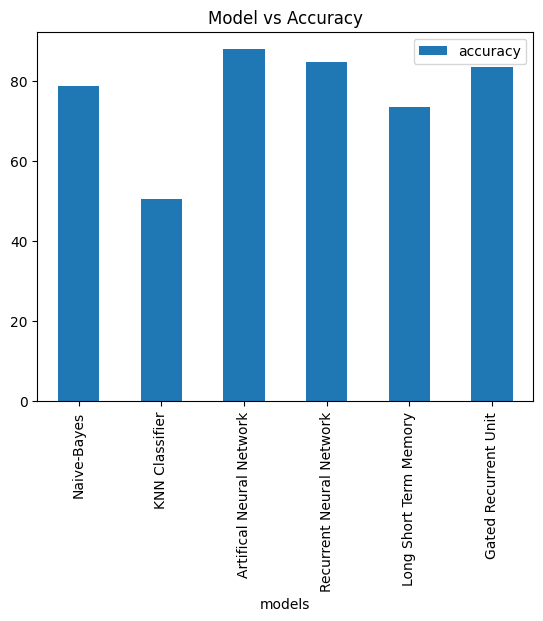

In [105]:
accuracy_df.plot(kind='bar',x="models",y="accuracy",title="Model vs Accuracy")

**As we can see from the above chart ANN model gives the highest accuracy.**